In [344]:
from yfinance import pdr_override
import pandas
from pandas_datareader.data import get_data_yahoo
from plotnine import ggplot, aes, geom_line, theme, element_text

pdr_override()

# Format date with year and month only
def drop_day(df):
    return df.apply(lambda x: x.strftime("%Y-%m"))

In [345]:
# Prepare data for monthly NAV of PYN Elite

elite = pandas.read_excel("NAV.xlsx", index_col="pvm")
elite = elite[~elite.index.to_period("m").duplicated()]
elite = elite[elite.index >= "2014-01-01"]

elite["Date"] = drop_day(elite.index.to_series())
elite["Quote"] = "PYN Elite"

elite

,NAV,Date,Quote
pvm,,,
2014-01-02,210.620,2014-01,PYN Elite
2014-02-03,223.520,2014-02,PYN Elite
2014-03-03,224.420,2014-03,PYN Elite
2014-04-01,223.550,2014-04,PYN Elite
2014-05-02,210.260,2014-05,PYN Elite
...,...,...,...
2022-08-01,454.661,2022-08,PYN Elite
2022-09-01,452.860,2022-09,PYN Elite
2022-10-03,380.287,2022-10,PYN Elite


In [346]:
# Prepare monthly data of NAV DXS7 baseline index for the same time period as PYN Elite

start_date = min(elite.index) + pandas.DateOffset(months=-1)
end_date = max(elite.index) + pandas.DateOffset(months=1)
vnetf = get_data_yahoo("DXS7.DE", start=start_date, end=end_date, interval="1mo")

vnetf["Date"] = drop_day(vnetf.index.to_series())
vnetf = pandas.DataFrame({"Date": vnetf["Date"], "NAV": list(vnetf["Open"])})
vnetf["Quote"] = "DXS7.DE"

# Save the data
vnetf.to_csv("dxs7.csv")

vnetf

[*********************100%***********************]  1 of 1 completed


,Date,NAV,Quote
Date,,,
2014-01-01,2014-01,17.650000,DXS7.DE
2014-02-01,2014-02,20.100000,DXS7.DE
2014-03-01,2014-03,20.230000,DXS7.DE
2014-04-01,2014-04,20.969999,DXS7.DE
2014-05-01,2014-05,19.740000,DXS7.DE
...,...,...,...
2022-08-01,2022-08,32.994999,DXS7.DE
2022-09-01,2022-09,34.810001,DXS7.DE
2022-10-01,2022-10,30.500000,DXS7.DE


In [347]:
# Stack index data for comparison and calculate relative NAV

index_long = pandas.concat([elite, vnetf]).set_index(["Quote", "Date"])
index_long["NAV %"] = index_long.groupby("Quote", group_keys=False)["NAV"].apply(lambda x: x/x.iloc[0] * 100)
index_long

NAV       NAV %
Quote     Date                           
PYN Elite 2014-01  210.620000  100.000000
          2014-02  223.520000  106.124774
          2014-03  224.420000  106.552084
          2014-04  223.550000  106.139018
          2014-05  210.260000   99.829076
...                       ...         ...
DXS7.DE   2022-08   32.994999  186.940508
          2022-09   34.810001  197.223808
          2022-10   30.500000  172.804536
          2022-11   26.070000  147.705384
          2022-12   22.459999  127.252122

[216 rows x 2 columns]

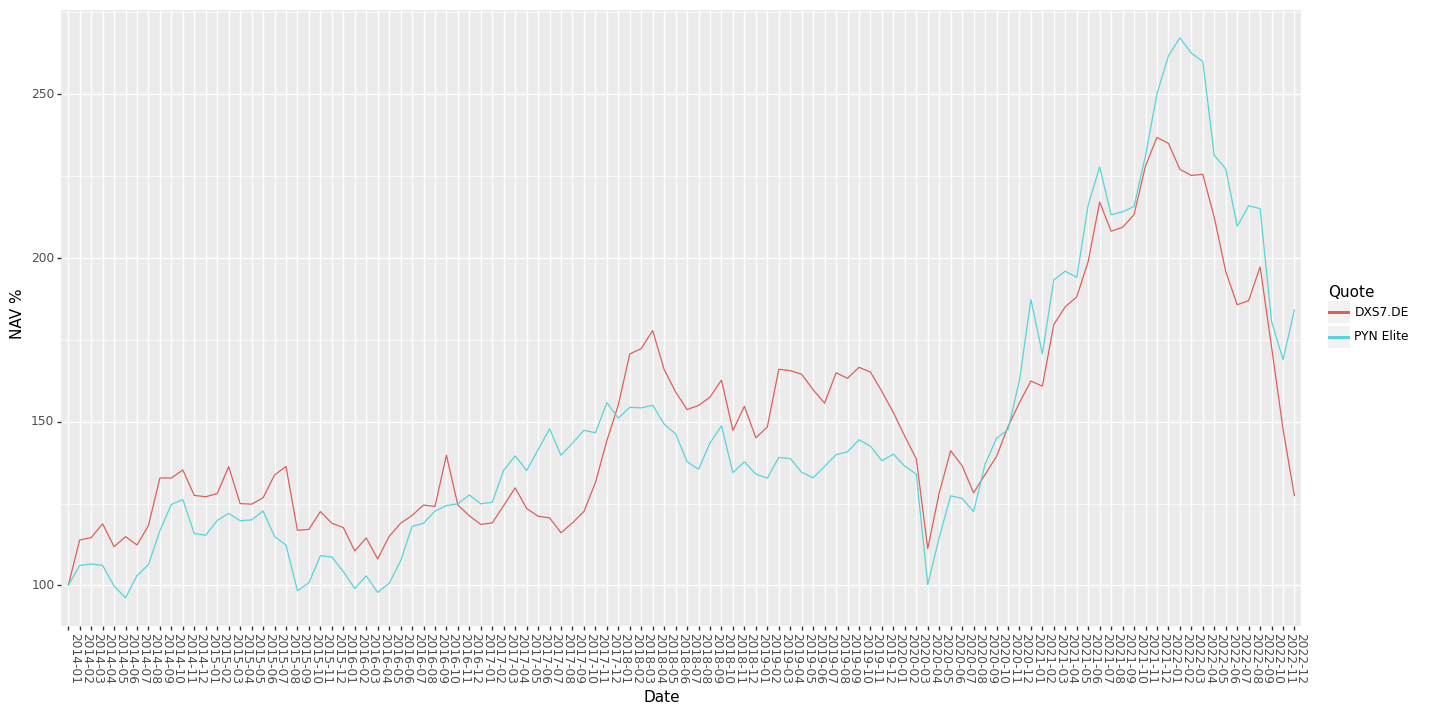

<ggplot: (8773674755844)>

In [348]:
(ggplot(index_long.reset_index(), aes("Date", "NAV %", group="Quote", color="Quote"))
    + geom_line()
    + theme(axis_text_x=element_text(angle = -90, hjust = 0))
    + theme(figure_size=(16, 8)))

In [350]:
index_wide = index_long.reset_index().pivot(index="Date", columns="Quote", values="NAV %")
diff = index_wide["PYN Elite"] - index_wide["DXS7.DE"]

# Number of months above baseline
print((diff > 0).sum(), diff.size)

# Average difference compared to baseline (pp)
print(diff.sum() / diff.size)

41 108
-2.1011152259772183
